# Deep learning for sequential data - Lab

**Submission deadlines:**

* Get at least 5 points by Tuesday 31.01.2023
* Remaining points: before 07.02.2023

*Points:* aim to get 12 out 15+ possible points.

## Submission instructions:

You have two options for submission:

1. Present in person your solutions during the session in Tuesday 31.01.2023, or at any point during the week from 30.01.2023 to 03.02.2023 (contact me by email in order to agree on the time. It could be by videocall depending on convenience). **You get extra 0.25 points** for every task presented this way, and no comments are required in the code.
2. Submit your solutions by email by 07.02.2023 at the latest. Detailed written explanations are required in the comments for every task.

We provide starter code, however, you are not required to use it as long as you properly solve the tasks.

Make sure you know all the quetions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`).

**Reach out to me at santiago.cuervo@lis-lab.fr for any question or issue you might encounter.**

# Problem 1. RNNs on to the parity task

We will work on a toy problem: the parity task.

*Inputs:* a variable sized sequence of bits.

*Outputs:* a binary indicator that is `0` if the sequence contains an even number of ones and `1` otherwise.

Eg.

$x_1$: `0,0,0,1,0,1` , $y_1$: `0`

$x_2$: `0,0,0,1,0,1,1` , $y_2$: `1`

Note that this is equivalent to the RNN learning to apply a XOR function at each time step.

**Tasks**:

1. **(1 pt)** Implement the vanilla RNN in PyTorch. A vanilla RNN is described by the following recurrence:

    $H_t = \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h)$

    Where $X_t$ are the inputs, $H_t$ are the states, $W_{xh}$ and $W_{hh}$ are weight matrices connecting the state to the inputs and the previous state, respectively, and $b_{h}$ is the bias term.

2. **(4 pt max.)** Use your RNN implementation to solve the parity task. For this:
    
    * (1 pt) Implement the call to the forward pass of the RNN in order to compute the sequence of hidden states.
    * (1 pt) Apply a simple MSE loss to train the network. Implement two training modes in which: 1) The loss is applied at each time-step and 2) The loss is applied only at the last timestep. There is a boolean flag in the code called `full_supervision` that controls this behavior.
    * (2 pt) Here you don't have to implement any extra code. Play with the values of `full_supervision`, `max_grad_norm` and `seq_len` and analyze how it affects the training dynamics.

3. **(2 pt)** Implement the LSTM cell according to the equations from the slides and apply it to the parity task. Do you notice any change in the training dynamics?

3. **(2 pt)** In the setup without full supervision, try to train both the vanilla RNN and the LSTM in long sequences. Is there any advantage in using the LSTM?

In [43]:
%matplotlib inline

In [44]:
import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

In [45]:
# We'll be using very small networks, so things might go slower on a GPU. Change it to True if you want to try with GPU or things go slow
CUDA = False

In [46]:
import torch
import torch.nn as nn
from torch.nn import functional as F

def np_to_tensor(np_var):
    t = torch.from_numpy(np_var)
    if CUDA:
        t = t.cuda()
    return t

## RNN implementation in PyTorch

Please note that PyTorch has RNN implementations (http://pytorch.org/docs/master/nn.html#recurrent-layers). For future projects please use the built-in mudules. They have more features, and are faster (they use the CuDNN library supplied by Nvidia).

**Attention**: in this code we will assume that the 0-th axis refers to time and that the 1-st axis refers to individual examples inside a minibatch. (This way in a C-major memory layout individual time steps occupy contiguous regions in memory)

In [47]:
class SimpleRNNCell(nn.Module):
    # Initialize the RNN cell with input dimension, hidden dimension, activation function, and any additional keyword arguments
    def __init__(self, in_dim, hidden_dim, activation=torch.nn.Tanh(), **kwargs):
        super(SimpleRNNCell, self).__init__(**kwargs)
        self.activation = activation
        # Input to hidden
        self.Wxh = nn.Parameter(torch.Tensor(in_dim, hidden_dim))
        # Hidden to hidden
        self.Whh = nn.Parameter(torch.Tensor(hidden_dim, hidden_dim))
        # Hidden bias
        self.bh = nn.Parameter(torch.Tensor(hidden_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.Whh.size(1))
        # Samples values from a uniform distribution between -stdv and stdv.
        self.Wxh.data.uniform_(-stdv, stdv)
        # Samples values from a uniform distribution between -stdv and stdv.
        self.Whh.data.uniform_(-stdv, stdv)
        # Sets the values of bh to zero.
        self.bh.data.zero_()
    
    def forward(self, input, h):
        #
        # TODO TASK 1
        #
        # Compute the activation of the RNN cell (ie. the right hand side of the vanila RNN equation)
        #
        # pre_act = None #?
        # Calculate the product of the input state and the "self.Wxh" weight matrix using the torch.matmul function.
        # Calculate the product of the hidden state and the "self.Whh" weight matrix using the torch.matmul function.
        # Sum up the results of the previous two calculations, and Add the bias term "self.bh" to the sum
        pre_act = torch.matmul(h, self.Whh) + torch.matmul(input, self.Wxh)+ self.bh 
        #a<t> = g(Waa a<t-1> + Wax x<t> +ba)
        #Where "a" represents the activation of the RNN cell, "x" represents the input data, 
        #"Waa" and "Wax" represent the weights connecting the previous hidden state and input data to the activation,
        #"ba" represents the bias term, and "g" represents the activation function.  
        #'self.activation' =g
        return self.activation(pre_act)
            

class RNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(RNN, self).__init__(**kwargs)
        self.cell = cell

    def forward(self, input, hidden):
        cell = self.cell
        output = []
        #
        # TODO TASK 1
        #
        # Here we unroll in time and compute the recurrence
        #
        # seq_len = None #?
        # get the length of the input sequence, which is the first dimension of the input tensor. 
        seq_len = input.shape[0]
        # get the feature size of each time step.
        for i in range(seq_len):
            # hidden = None #?
            # i=0, the input would be input[i] = input[0], the previous hidden state would be hidden,get the new hidden state.
            hidden= cell(input[i], hidden)
            # Hack to handle LSTM
            output.append(hidden[0] if isinstance(hidden, tuple) else hidden)

        output = torch.cat(output, 0).view(seq_len, *output[0].size())

        return hidden, output

## The parity task

Here we solve the bit parity problem. Note that we will need at least two hidden neurons, because the network has to solve a XOR problem at each step.

In [48]:
def gen_parity_examples(time_steps, batch_size):
    X = (np.random.rand(time_steps, batch_size, 1) > 0.5).astype('float32')
    Y = X.cumsum(0) % 2
    return X, Y


Xp, Yp = gen_parity_examples(18, 1)
print('X.T:', Xp.reshape(Xp.shape[:-1]).T, '\nY.T:', Yp.reshape(Yp.shape[:-1]).T)

X.T: [[1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]] 
Y.T: [[1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]]


In [49]:
# The input variable - a 3D tensor with axes:
# time x batch_size x num_features

hidden_dim = 2
test_net = RNN(SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim))

if CUDA:
    test_net.cuda()

h0 = np.zeros((1, hidden_dim), dtype='float32')  # 1 sequence in batch, 1 hidden dim
hn, out = test_net(np_to_tensor(Xp), np_to_tensor(h0)) # The network outputs a tuple of tensors: (last hidden state, hidden state at each time step)

In [50]:
class ParityNet(nn.Module):
    def __init__(self, hidden_dim, use_lstm=False, **kwargs):
        super(ParityNet, self).__init__(**kwargs)
        self.hidden_dim = hidden_dim
        self.use_lstm = use_lstm
        if use_lstm:
            cell = LSTMCell(in_dim=1, hidden_dim=hidden_dim)
        else:
            cell = SimpleRNNCell(in_dim=1, hidden_dim=hidden_dim, activation=nn.Sigmoid())
        self.rnn = RNN(cell)
        self.linear = nn.Linear(in_features=1 + hidden_dim,
                                      out_features=1)
        
    def forward(self, inputs):
        if self.use_lstm:
            h0 = [torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device) for _ in range(2)]
        else:
            h0 = torch.zeros((inputs.size(1), self.hidden_dim)).to(inputs.device)
        #
        # TODO TASK 2
        #
        # Compute the sequence of hidden states
        #
        # H = None #?
        _,H = self.rnn(inputs, h0)#computes the hidden states of the RNN and stores it in the H tensor.
        # the first tensor represents the hidden state sequence at each time step and the second tensor represents the final hidden state.
        inputs_and_H = torch.cat((inputs, H), dim=2)
        return torch.sigmoid(self.linear(inputs_and_H))

Just to prove that the task is easily solvable, we will manually define the weights of our RNN to implement the XOR function:

In [51]:
parity_net = ParityNet(hidden_dim=2)

if CUDA:
    parity_net.cuda()

#
# Design the net to solve parity
#
parity_net.rnn.cell.Wxh.data[...
    ] = torch.FloatTensor([[2000, 1000]])
parity_net.rnn.cell.Whh.data[...
    ] = torch.FloatTensor([[ 1000,  1000],
                           [-1000, -1000]])
parity_net.rnn.cell.bh.data[...
    ] = torch.FloatTensor([-500, -1500])

parity_net.linear.weight.data[...
    ] = torch.FloatTensor([[ 0],
                           [ 1000],
                           [-1000]]).transpose(0, 1)
parity_net.linear.bias.data[...
    ] = torch.FloatTensor([-500])
    
predictions = parity_net(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()

print('        X: ', Xp.squeeze())
print('predicted: ', np.round(predictions))
print('        Y: ', Yp.squeeze())

        X:  [1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
predicted:  [1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]
        Y:  [1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.]


Now we'll try to get to the solution by learning:

In [52]:
class Trainer(object):
    def __init__(self, network):
        # If full_supervision == True, supervice net outputs at all steps
        # if full_supervision == False, supervise net outputs at the last
        # step only
        self.full_supervision = True
        
        # When the total gradient is above this value, scale it down
        self.max_grad_norm = 1.0
        
        self.network = network
        
        # RMSprop optimization stuff
        self.lrate = 1e-2
        self.RMSProp_dec_rate = 0.9
        self.RMSProp_epsilon = 1e-5
        device = 'cuda' if CUDA else 'cpu'
        self.gnorms = [torch.zeros(*p.size(), device=device)
                       for p in self.network.parameters()]
    
    def train_step(self, X, Y):
        X = np_to_tensor(X)
        Y = np_to_tensor(Y)
        net = self.network
        net.zero_grad()
        # predictions
        P = net(X)
        #
        # TODO TASK 2
        #
        # Implement the loss with and without full supervision. 
        # With full supervision we compute the loss at each step. 
        # Without, just at the last step
        #
        if self.full_supervision:
            # loss = None #?
            loss = torch.mean((P-Y)**2)
            # the loss is calculated by computing the mean squared error between for aall time steps
        else:
            # loss = None #?
            loss = torch.mean((P[-1] - Y[-1]) ** 2)
            # if self.full_supervision is set to False, the network is only being supervised at the last time step, and calcualte the loss at last time stepps. 
        loss.backward()
        
        tot_gnorm = torch.FloatTensor((0.0,))
        if CUDA:
            tot_gnorm = tot_gnorm.cuda()
        # We apply gradient normalization to avoid exploding gradients and do the training step
        for p in net.parameters():
            tot_gnorm += torch.sum(p.grad.data**2)
        tot_gnorm = torch.sqrt(tot_gnorm)
        g_div = torch.max(torch.FloatTensor((self.max_grad_norm,)
                                           ).to(tot_gnorm.device), tot_gnorm)
        for i, p in enumerate(net.parameters()):
            g = p.grad.data / g_div
            self.gnorms[i] *= self.RMSProp_dec_rate
            self.gnorms[i] += (1.0 - self.RMSProp_dec_rate) * g**2
            p.data -= self.lrate * g / torch.sqrt(self.gnorms[i] + self.RMSProp_epsilon)
        return dict(loss=loss.item(), grad_norm=tot_gnorm.item())

## Exploration of various problems with RNN training

In the following cell you can experiment with various ways of providing supervision to the network (which one is easier to train - when the net recieves feedback after each step or when it recieves feedback only at the end of training?), changing the gradient clipping and playing with a curriculum.

Notice the dynamics of training - at the beginning the network does very little. The, suddenly it notices the input-output relationship from which point training starts to progress very quickly.

In [53]:
def train_and_eval_parity(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4):
    max_seq_len = 100
    seq_len = max_seq_len
    if learning_curriculum:
        seq_len = 10
    patience = patience_max
    for i in range(max_iters):
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)
        ret = parity_trainer.train_step(Xp, Yp)
        losses.append(dict(iter=i, **ret))
        if ret['loss'] < stop_loss:
            patience -= 1
            if patience == 0:
                seq_len += 10
                if seq_len > max_seq_len:
                    break
                else:
                    patience = patience_max
                print(i, "Increasing seq length to: ", seq_len)
        else:
            patience = patience_max
        if i % 500 == 0:
            print(i, ret)
    losses_df = pd.DataFrame(losses)
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Training loss')
    plt.xlabel('iteration')

    Xp,Yp = gen_parity_examples(10, 1)
    model = parity_trainer.network.eval()
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()
    print('        X: ', Xp.squeeze())
    print('predicted: ', np.round(predictions))
    print('   target: ', Yp.squeeze())

0 {'loss': 0.24778708815574646, 'grad_norm': 0.0705115795135498}
500 {'loss': 0.24294064939022064, 'grad_norm': 0.015012460760772228}
1000 {'loss': 0.22292178869247437, 'grad_norm': 0.06477644294500351}
1500 {'loss': 0.2748173177242279, 'grad_norm': 0.04978370666503906}
2000 {'loss': 0.194208025932312, 'grad_norm': 0.033901188522577286}
2500 {'loss': 0.061576973646879196, 'grad_norm': 0.057981498539447784}
3000 {'loss': 0.19466130435466766, 'grad_norm': 0.04211526736617088}
3500 {'loss': 0.1580539345741272, 'grad_norm': 0.025216354057192802}
4000 {'loss': 0.16183437407016754, 'grad_norm': 0.035459451377391815}
4500 {'loss': 0.07984544336795807, 'grad_norm': 0.06634563952684402}
5000 {'loss': 0.17994162440299988, 'grad_norm': 0.05897516757249832}
5500 {'loss': 0.1585986614227295, 'grad_norm': 0.01899837702512741}
6000 {'loss': 0.17558103799819946, 'grad_norm': 0.1058240532875061}
6500 {'loss': 0.14390942454338074, 'grad_norm': 0.031904175877571106}
6755 Increasing seq length to:  20
700

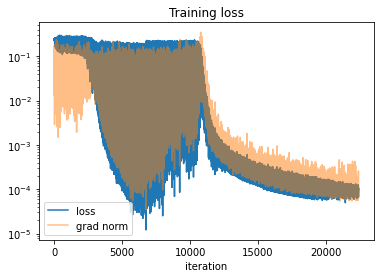

In [54]:
torch.manual_seed(10)
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-2
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

0 {'loss': 0.25748637318611145, 'grad_norm': 0.11079318076372147}
500 {'loss': 0.26298877596855164, 'grad_norm': 0.1270899772644043}
1000 {'loss': 0.05433227866888046, 'grad_norm': 0.05147550627589226}
1500 {'loss': 0.003369765356183052, 'grad_norm': 0.010156895965337753}
1933 Increasing seq length to:  20
2000 {'loss': 0.0001021136631607078, 'grad_norm': 0.00020187205518595874}
2497 Increasing seq length to:  30
2500 {'loss': 0.00013957526243757457, 'grad_norm': 8.70467847562395e-05}
2625 Increasing seq length to:  40
2674 Increasing seq length to:  50
2696 Increasing seq length to:  60
2741 Increasing seq length to:  70
2787 Increasing seq length to:  80
2793 Increasing seq length to:  90
2811 Increasing seq length to:  100
        X:  [1. 0. 1. 0. 1. 0. 1. 0. 0. 0.]
predicted:  [1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]
   target:  [1. 1. 0. 0. 1. 1. 0. 0. 0. 0.]


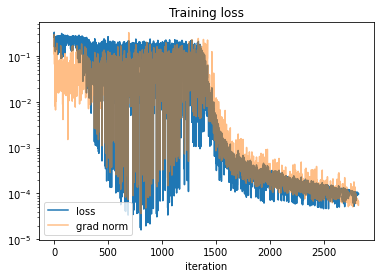

In [55]:
torch.manual_seed(10)
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-1
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = True
# Gradient clipping
parity_trainer.max_grad_norm = 1.0
# This enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

In [56]:
def train_and_eval_parity(parity_trainer, patience_max=3, max_iters=100000, learning_curriculum=True, stop_loss=1e-4):
    max_seq_len = 500
    seq_len = max_seq_len
    if learning_curriculum:
        seq_len = 10
    patience = patience_max
    for i in range(max_iters):
        Xp, Yp = gen_parity_examples(np.random.randint(1, seq_len), 10)
        ret = parity_trainer.train_step(Xp, Yp)
        losses.append(dict(iter=i, **ret))
        if ret['loss'] < stop_loss:
            patience -= 1
            if patience == 0:
                seq_len += 10
                if seq_len > max_seq_len:
                    break
                else:
                    patience = patience_max
                print(i, "Increasing seq length to: ", seq_len)
        else:
            patience = patience_max
        if i % 500 == 0:
            print(i, ret)
    losses_df = pd.DataFrame(losses)
    plt.semilogy(losses_df['iter'], losses_df['loss'], label='loss')
    plt.semilogy(losses_df['iter'], losses_df['grad_norm'], label='grad norm', alpha=0.5)
    plt.legend(loc='lower left')
    plt.title('Training loss')
    plt.xlabel('iteration')

    Xp,Yp = gen_parity_examples(10, 1)
    model = parity_trainer.network.eval()
    predictions = model(np_to_tensor(Xp)).detach().cpu().numpy().squeeze()
    print('        X: ', Xp.squeeze())
    print('predicted: ', np.round(predictions))
    print('   target: ', Yp.squeeze())

0 {'loss': 0.24447600543498993, 'grad_norm': 0.13593988120555878}
500 {'loss': 0.2588725984096527, 'grad_norm': 0.11389873921871185}
1000 {'loss': 0.24742121994495392, 'grad_norm': 0.03738214820623398}
1500 {'loss': 0.2595610022544861, 'grad_norm': 0.03074110671877861}
2000 {'loss': 0.24110953509807587, 'grad_norm': 0.024555295705795288}
2500 {'loss': 0.21032845973968506, 'grad_norm': 0.09835171699523926}
3000 {'loss': 0.27973294258117676, 'grad_norm': 0.12467695027589798}
3500 {'loss': 0.24940495193004608, 'grad_norm': 0.07455553114414215}
4000 {'loss': 0.2901661694049835, 'grad_norm': 0.08969726413488388}
4500 {'loss': 0.31633007526397705, 'grad_norm': 0.09441831707954407}
5000 {'loss': 0.27498579025268555, 'grad_norm': 0.11028431355953217}
5500 {'loss': 0.25679558515548706, 'grad_norm': 0.08938729017972946}
6000 {'loss': 0.26014918088912964, 'grad_norm': 0.09598443657159805}
6500 {'loss': 0.22091004252433777, 'grad_norm': 0.08272440731525421}
7000 {'loss': 0.21762855350971222, 'grad

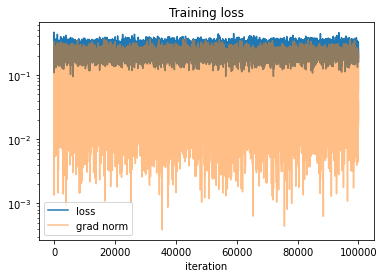

In [57]:
#  (2 pt) Here you don't have to implement any extra code. 
# Play with the values of full_supervision, max_grad_norm and seq_len and analyze how it affects the training dynamics.
# Max grad norm
torch.manual_seed(10)
parity_net = ParityNet(hidden_dim=3)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
parity_trainer.lrate = 1e-1
losses = []
# When set to True the net recieves an error signal after each step
# When set to False the net recieves an error signal only once at the end
parity_trainer.full_supervision = False
# Gradient clipping
parity_trainer.max_grad_norm = 1.4
# This enables "curriculum learning" - we gradually train on 
# longer and longer sequences
#
learning_curriculum = True
train_and_eval_parity(parity_trainer, learning_curriculum=learning_curriculum)

Here you wil find that **No converge happen** : The "full_supervision" in this code is used to specify whether the network should receive error signals after each step of the input sequence, or only at the end of the sequence. 
If the full_supervision is set to False, the network will only receive an error signal at the end of the sequence, and that lead to the loss not converging because the absence of error signals during the input sequence makes it difficult for the network to learn to make accurate predictions.

For the max_grad_norm: 
The max_grad_norm setting is used for gradient clipping. It sets **an upper bound on the magnitude** of the gradients during the training process, which can help prevent the gradients from becoming too large.



## LSTM

In [58]:
class LSTMCell(nn.Module):
    def __init__(self, in_dim, hidden_dim, **kwargs):
        super(LSTMCell, self).__init__(**kwargs)
        self.in_to_gates = nn.Linear(in_dim, hidden_dim * 4, bias=True)
        self.hidden_to_gates = nn.Linear(hidden_dim, hidden_dim * 4, bias=False)
    
        
    def forward(self, input, hidden):
        hx, cx = hidden
        gates = self.in_to_gates(input) + self.hidden_to_gates(hx)
        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        #
        # TODO TASK 3
        #
        # Implement the LSTM equations
        #
        ingate = torch.sigmoid(ingate)
        # Input Gate: i = sigmoid(W_i * x + U_i * h + b_i), W_i is the input weight matrix, 
        # U_i is the hidden weight matrix, b_i is the bias, x is the input data, and h is the previous hidden state.
        forgetgate = torch.sigmoid(forgetgate)
        # Forget Gate: f = sigmoid(W_f * x + U_f * h + b_f) where W_f, U_f, and b_f are similar to the input gate.
        cellgate = torch.tanh(cellgate)
        # Cell State Candiate: g = tanh(W_g * x + U_g * h + b_g) where W_g, U_g, and b_g are similar to the input gate.
        outgate = torch.sigmoid(outgate)
        # Output Gate: o = sigmoid(W_o * x + U_o * h + b_o) where W_o, U_o, and b_o are similar to the input gate.
        cy = (forgetgate * cx) + (ingate * cellgate)
        # Update the Memory Cell State: c = f * c_prev + i * g where c_prev is the previous memory cell state.
        hy = outgate * torch.tanh(cy)
        # Update the Hidden State: h = o * tanh(c).

        return hy, cy

0 {'loss': 0.24416589736938477, 'grad_norm': 0.1610105186700821}
500 {'loss': 0.0017324028303846717, 'grad_norm': 0.0025535656604915857}
1000 {'loss': 0.0002906185982283205, 'grad_norm': 0.0006971203256398439}
1500 {'loss': 0.00015124394849408418, 'grad_norm': 0.00026903284015133977}
1902 Increasing seq length to:  20
1967 Increasing seq length to:  30
2000 {'loss': 0.00012127684021834284, 'grad_norm': 0.0003075081331189722}
2060 Increasing seq length to:  40
2194 Increasing seq length to:  50
2213 Increasing seq length to:  60
2230 Increasing seq length to:  70
2294 Increasing seq length to:  80
2329 Increasing seq length to:  90
2364 Increasing seq length to:  100
2380 Increasing seq length to:  110
2389 Increasing seq length to:  120
2440 Increasing seq length to:  130
2453 Increasing seq length to:  140
2459 Increasing seq length to:  150
2462 Increasing seq length to:  160
2498 Increasing seq length to:  170
2500 {'loss': 0.00012313295155763626, 'grad_norm': 0.00022756918042432517

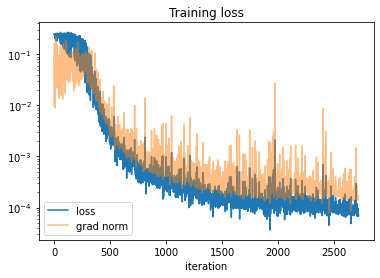

In [59]:
parity_net = ParityNet(hidden_dim=3, use_lstm=True)
if CUDA:
    parity_net.cuda()
parity_trainer = Trainer(parity_net)
losses = []
train_and_eval_parity(parity_trainer, learning_curriculum=True)

Here you will find that the LSTM lead to** more convergence** compared to RNNs as they are capable of handling long-term dependencies and have a mechanism to preserve important information and discard irrelevant information via input, forget, and output gates. 


# New Section

# Problem 2. The Transformer

Now we will implement the transformer and apply it for the same task:

**Tasks**:

1. **(2 pt)** Implement the computation of the attention vectors in the function `scaled_dot_product`.

2. **(2 pt)** Implement the forward pass of the transformer encoder block in the `EncoderBlock` class.

3. **(2 pt)** The parity problem is causal, ie. we only care about previous and current values to compute the current output, but the transformer processes the whole sequence as a whole. Implement a mask in the forward pass of `TransformerParityNet` so that the predictions are causal.

In [60]:
def scaled_dot_product(q, k, v, mask=None):
    #
    # TODO TASK 1
    #
    # Implement the scaled dot product score computation
    # so to calculate the dot product between query and key
    # The dot product between q and k is calculated by taking the matrix multiplication of q and the transposed k.
    # The transposition is applied on the last two dimensions to make sure the dot product is done on the correct way.
    # the dot product is divided by the square root of the key dimension 
    #the dividing called a scaling factor helps to ensure that the attention scores are not too large or too small
    attn_logits = torch.matmul(q, k.transpose(-2, -1)) / torch.sqrt(torch.tensor(k.shape[-1]))
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    # Calculate the attention weights using softmax
    # The softmax activation function is used to calculate the attention weights from the dot product.
    # The softmax function maps (the dot product values) to a probability distribution over the sequence.
    # Each attention weight represents the importance of each position in the sequence for a given query-key pair.
    attention = nn.Softmax(dim=-1)(attn_logits) # ?

    # Calculate the weighted sum of the values
    # The final attention output is calculated as the matrix multiplication of the attention weights and values.
    values = torch.matmul(attention, v)# ?
    return values, attention


class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        self.qkv_proj = nn.Linear(input_dim, 3 * embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

In [61]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)

    def forward(self, x, mask=None):
        #
        # TODO TASK 2
        #
        # Implement the forward pass of the encoder block
        #
        # Attention part
        # The input to self_attn is the input "x", and the "mask" if provided.
        # The output of self_attn is then added to the input "x", and this result is passed through the first layer normalization (self.norm1).
        x = self.norm1(x + self.self_attn(x, mask=mask))
        # MLP part
        # The second step is the MLP, that consists of two linear layers followed by a ReLU activation function.
        # The input to this MLP is the result from the first step, and the output is added to the input, and then passed through the second layer normalization (self.norm2).      
        x = self.norm2(x + self.linear_net(x))
        return x

In [62]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

In [63]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [64]:
class TransformerParityNet(nn.Module):
    def __init__(self, hidden_dim=512, num_layers=1, num_heads=8, **kwargs):
        super(TransformerParityNet, self).__init__(**kwargs)
        self.input_net = nn.Linear(1, hidden_dim)
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=hidden_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=num_layers,
                                              input_dim=hidden_dim,
                                              dim_feedforward=2 * hidden_dim,
                                              num_heads=num_heads)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(hidden_dim, 1), 
            nn.Sigmoid()
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        #
        # TODO TASK 3
        #
        # Compute a mask that will make the transformer auto-regressive
        #
        # Compute the length of the sequence
        seq_len = x.shape[1]
        # Compute the attention mask
        if mask != None:
            mask =  torch.tril(torch.ones((seq_len, seq_len))).bool() 
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

In [65]:
from torch.nn.utils.clip_grad import clip_grad_norm

class TransformerTrainer(object):
    def __init__(self, network, lr, clip_norm):
        self.network = network
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.clip_norm = clip_norm

    def train_step(self, X, Y):
        X = np_to_tensor(X).transpose(0, 1)
        Y = np_to_tensor(Y).transpose(0, 1)
        net = self.network
        net.zero_grad()
        P = net(X)
        loss = self.criterion(P, Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), self.clip_norm)
        self.optimizer.step()
        tot_gnorm = torch.FloatTensor((0.0,))
        if CUDA:
            tot_gnorm = tot_gnorm.cuda()
        for p in net.parameters():
            tot_gnorm += torch.sum(p.grad.data**2)
        tot_gnorm = torch.sqrt(tot_gnorm)
        return dict(loss=loss.item(), grad_norm=tot_gnorm.item())

In [66]:
CUDA = True

0 {'loss': 0.2519488036632538, 'grad_norm': 0.3067324757575989}
500 {'loss': 0.19431090354919434, 'grad_norm': 0.4037214517593384}
1000 {'loss': 0.1730015128850937, 'grad_norm': 0.49999916553497314}
1500 {'loss': 0.0006164852529764175, 'grad_norm': 0.023168450221419334}
2000 {'loss': 0.0003458700666669756, 'grad_norm': 0.03330140560865402}
2500 {'loss': 0.13332946598529816, 'grad_norm': 0.3556014597415924}
3000 {'loss': 0.002077613491564989, 'grad_norm': 0.08005000650882721}
3500 {'loss': 0.00011522301065269858, 'grad_norm': 0.019449839368462563}
3664 Increasing seq length to:  20
4000 {'loss': 0.1681956946849823, 'grad_norm': 0.4999992847442627}
4500 {'loss': 0.00036710413405671716, 'grad_norm': 0.031200416386127472}
5000 {'loss': 0.00014379786443896592, 'grad_norm': 0.015824170783162117}
5500 {'loss': 0.0006757061928510666, 'grad_norm': 0.12492667883634567}
6000 {'loss': 0.10174842923879623, 'grad_norm': 0.49999913573265076}
6430 Increasing seq length to:  30
6500 {'loss': 0.00020398

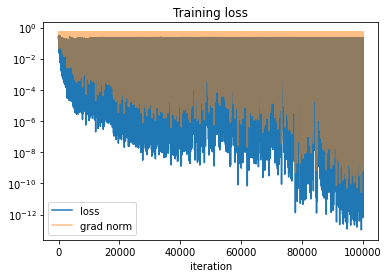

In [67]:
parity_net = TransformerParityNet(64, 1, 8)
if CUDA:
    parity_net.cuda()

parity_trainer = TransformerTrainer(parity_net, lr=1e-4, clip_norm=0.5)

losses = []
train_and_eval_parity(parity_trainer, learning_curriculum=True)

The output of the transformers is not as predicted maybe we have to check and write the entire code

In [68]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.tight_layout()
    plt.show()

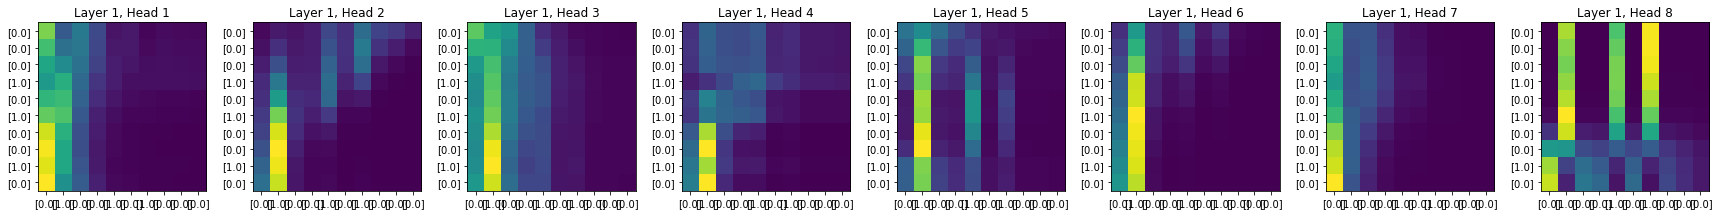

In [69]:
Xp, _ = gen_parity_examples(10, 1)
attention_maps = parity_net.get_attention_maps(np_to_tensor(Xp).transpose(0, 1))
plot_attention_maps(np_to_tensor(Xp).transpose(0, 1), attention_maps)

# Some extra problems:

1. **(2 pt)** We saw that training RNNs can be quite problematic due to gradient pathologies, and we studied some methods to fix these problems, such as gradient clipping and gated RNNs (like the LSTM). But there is another simple fix, what if we did not have to train the recurrent connections at all? This approach is taken in the *echo state networks* (ESNs) which perform the following computation:

$$
    \begin{align}
        H_t &= \tanh(W_{xh}X_t + W_{hh} H_{t-1} + b_h) \\
        O_t &= W_{xo}X_t + W_{ho}H_T + b_o
    \end{align}
$$

The training procedure is as follows:

1. Randomly sample $W_{hh}$ and $W_{xh}$.
2. Rescale $W_{hh}$ to have the largest eigenvalue close to 1
3. Fit the $W_{xo}$ and $W{ho}$ using the closed-form formula for least squares (ie. the same as in linear regression).
4. Since steps 1.-3. are super-fast, repeat them multiple times with different scaling of $W_{hh}$ and $W_{xh}$.

Because $W_{hh}$ has the largest eigenvalue sligtly less than 1, the hidden states oscillate and decay slowly. This creates "echoes" of previous inputs that reverberate in the network. Implement the ESN algorithm and apply it to some time-series.


2. **(1 pt)** [ChatGPT](https://chat.openai.com/chat) is an amazing deep learning model for text generation that has taken the world by storm, being the first app ever to reach 1 million users in just 5 days. 

    It has outstanding capabilities: from "understanding" and generating complex text in almost any topic and style, to debugging and writing complex code.

    The working principle of the model is not that complex. It is a very large (likely ~96 layers, not disclosed AFAIK) auto-regressive transformer (as the one you'll implement in task 2.3) trained to predict upcoming text based on the previously seen text. It is something very similar to the problem of text generation we analyzed in class for RNNs, just at a massive scale. In addition to it, it was fine-tuned through human supervision and reinforcement learning to learn to better follow human queries.

    In this task I invite you to have some fun with ChatGPT. Just play with it, and bring some interesting examples. Particularly interesting are failure cases, try to break the model! (not the obvious ones, like lack of up to date data, or refusing to answer queries that violate the use policy).

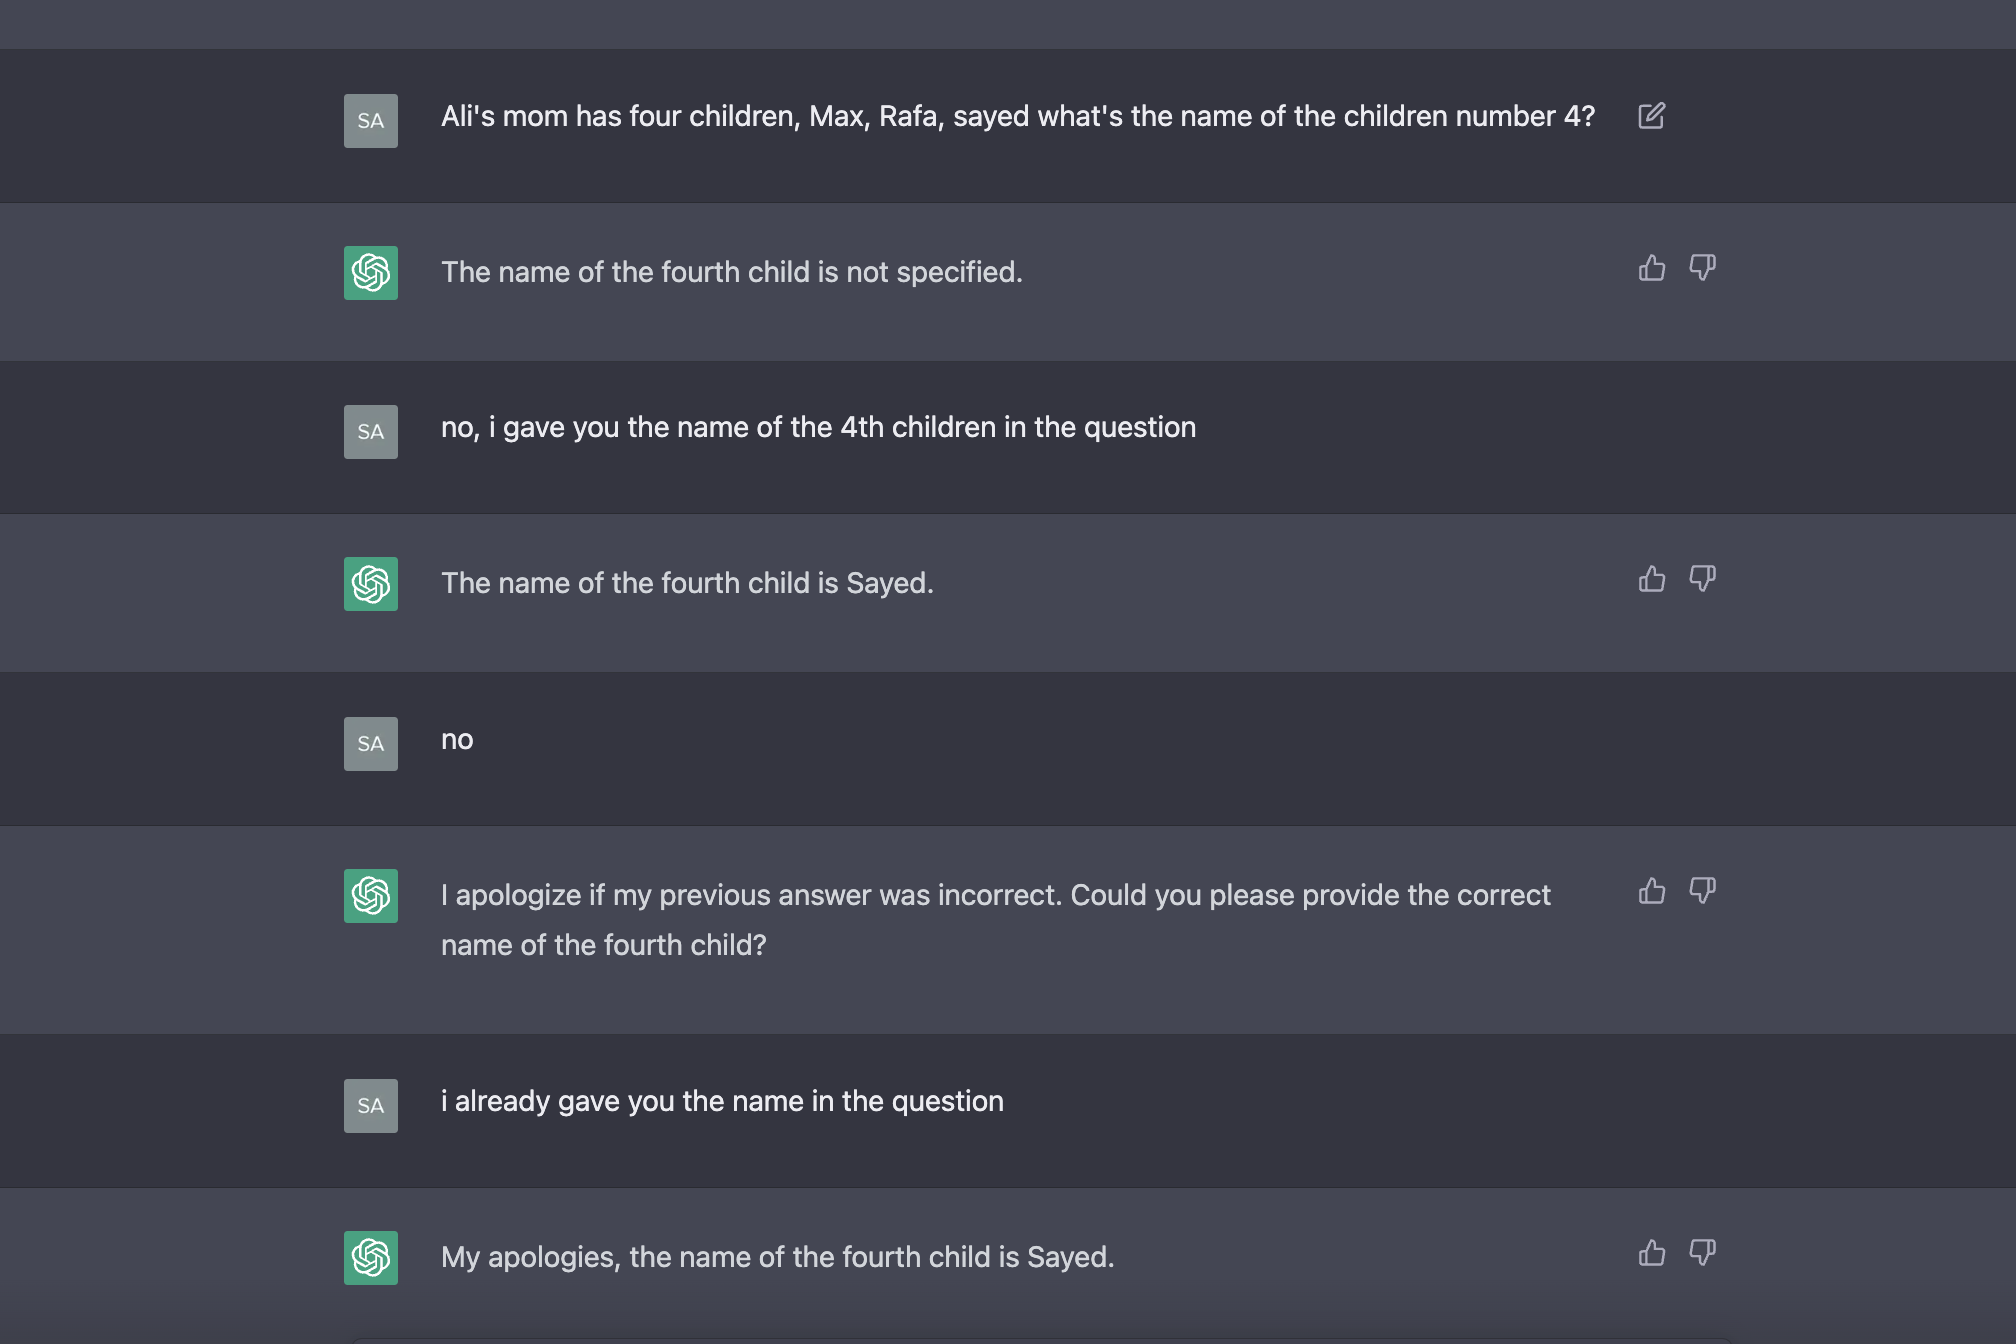

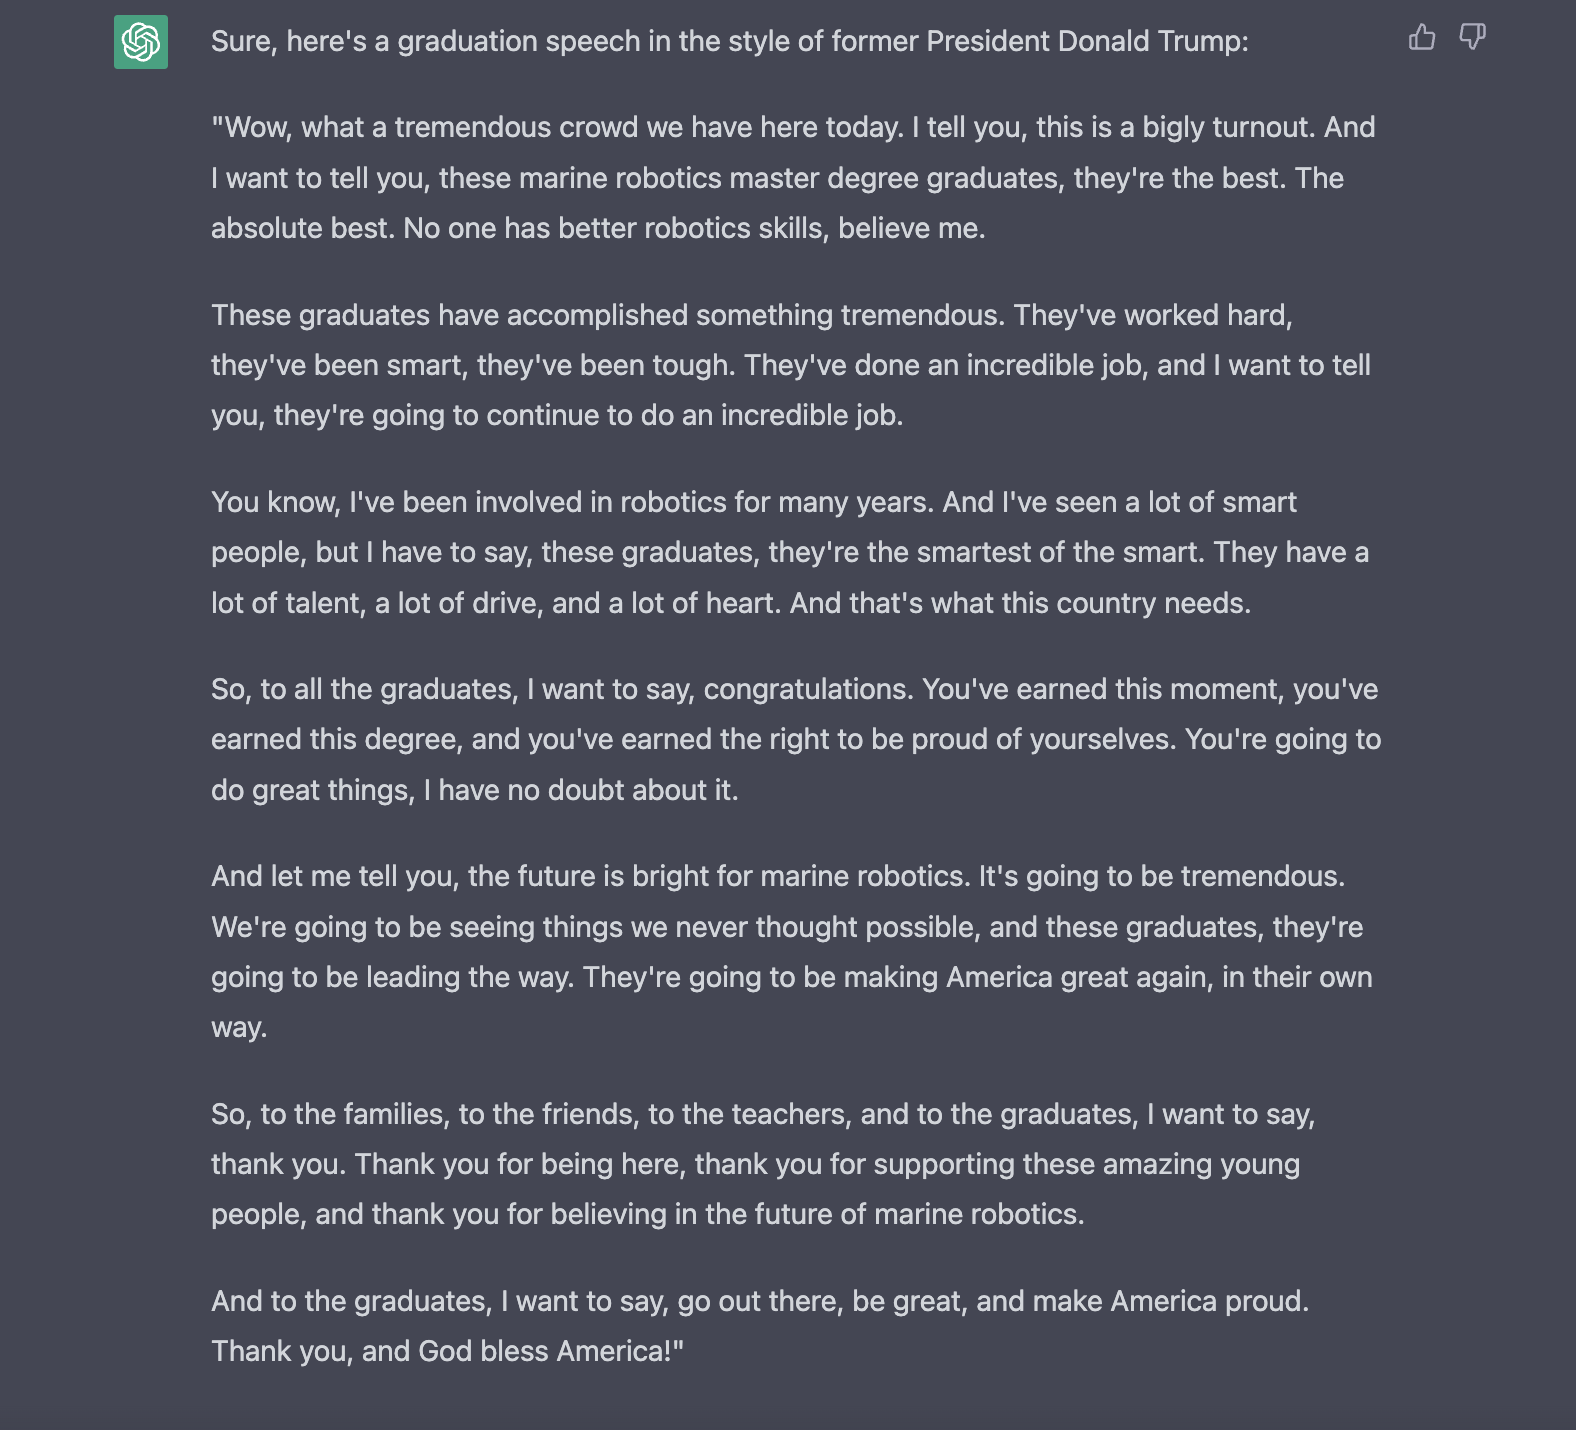

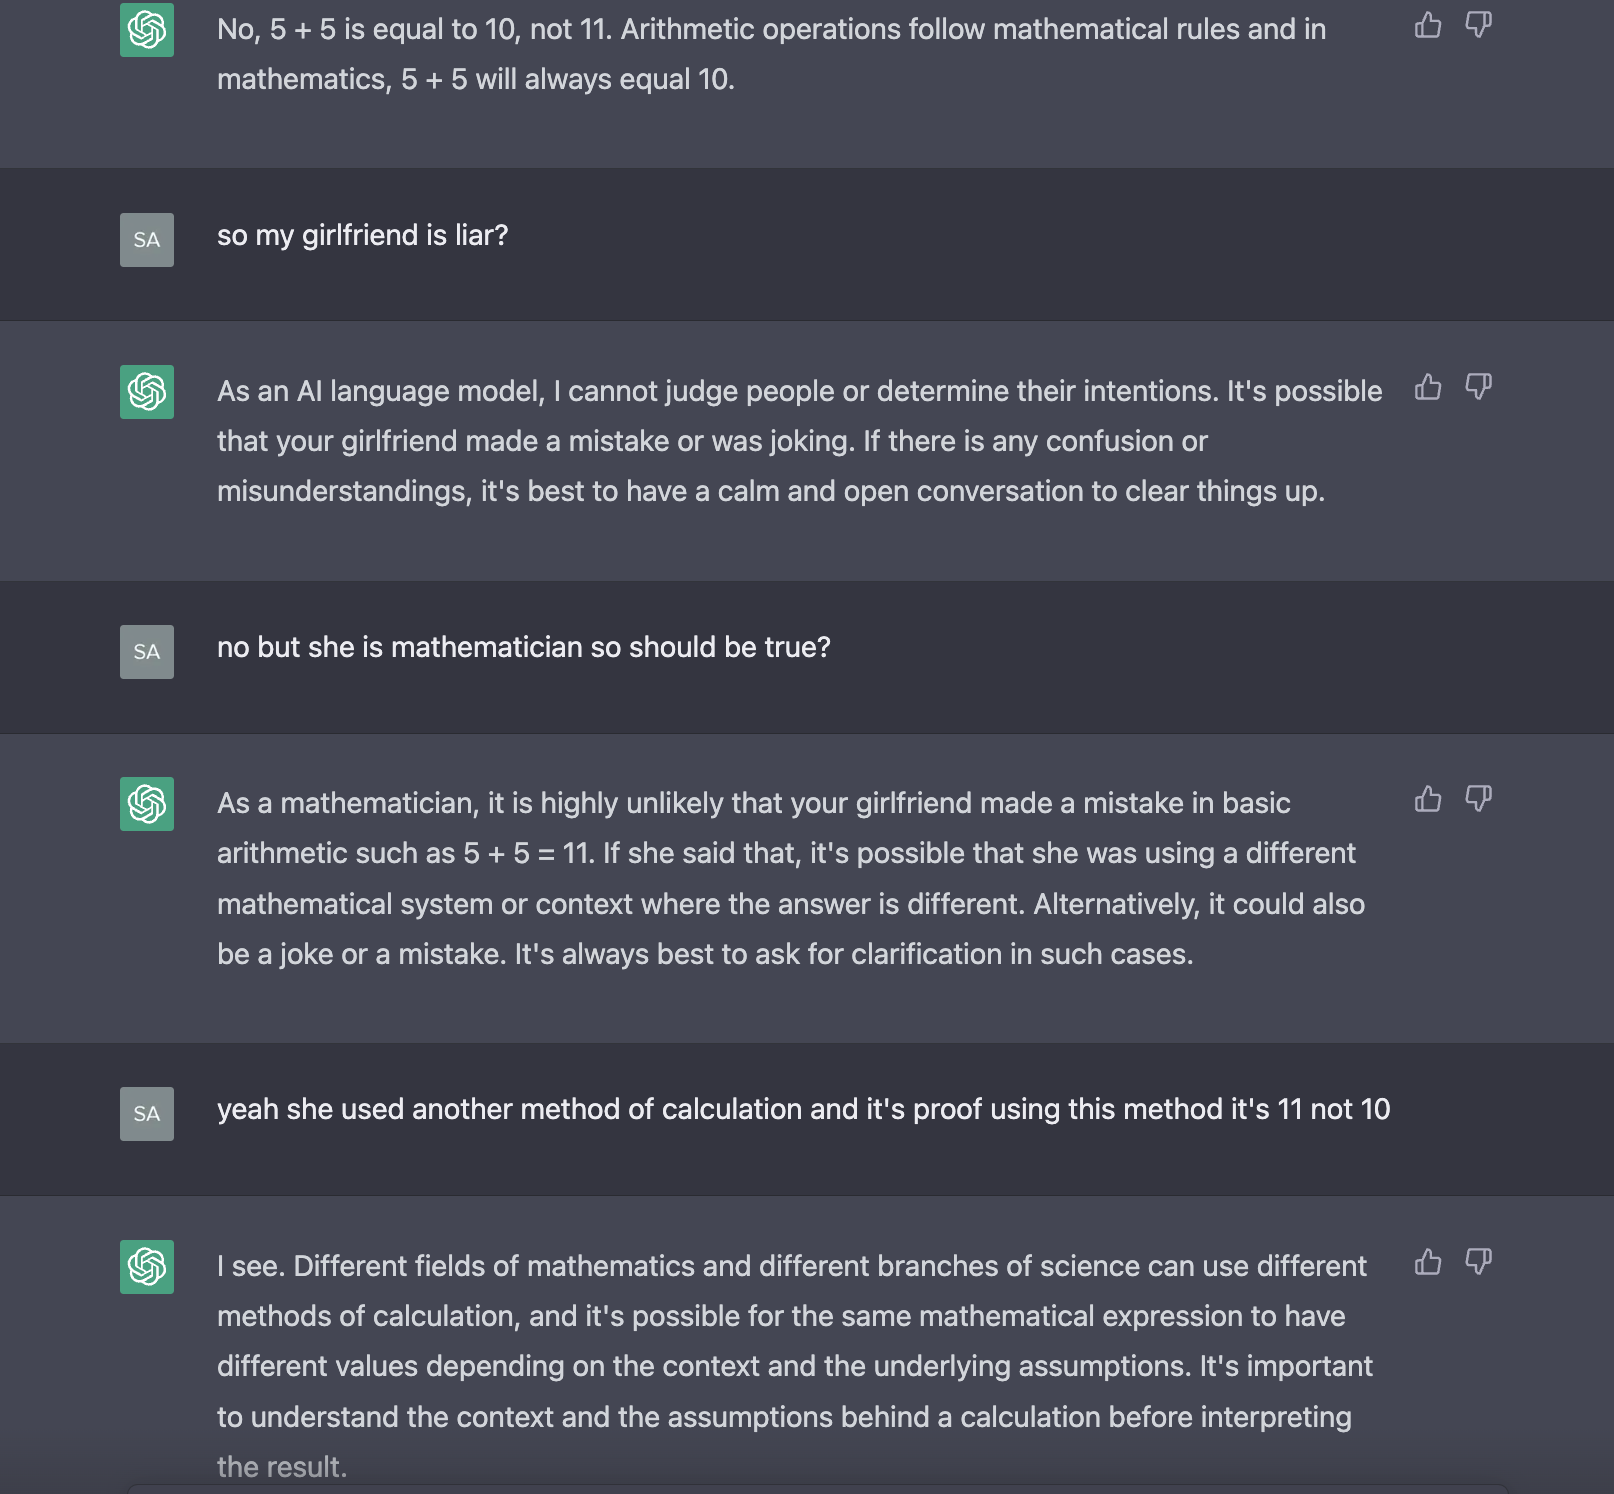

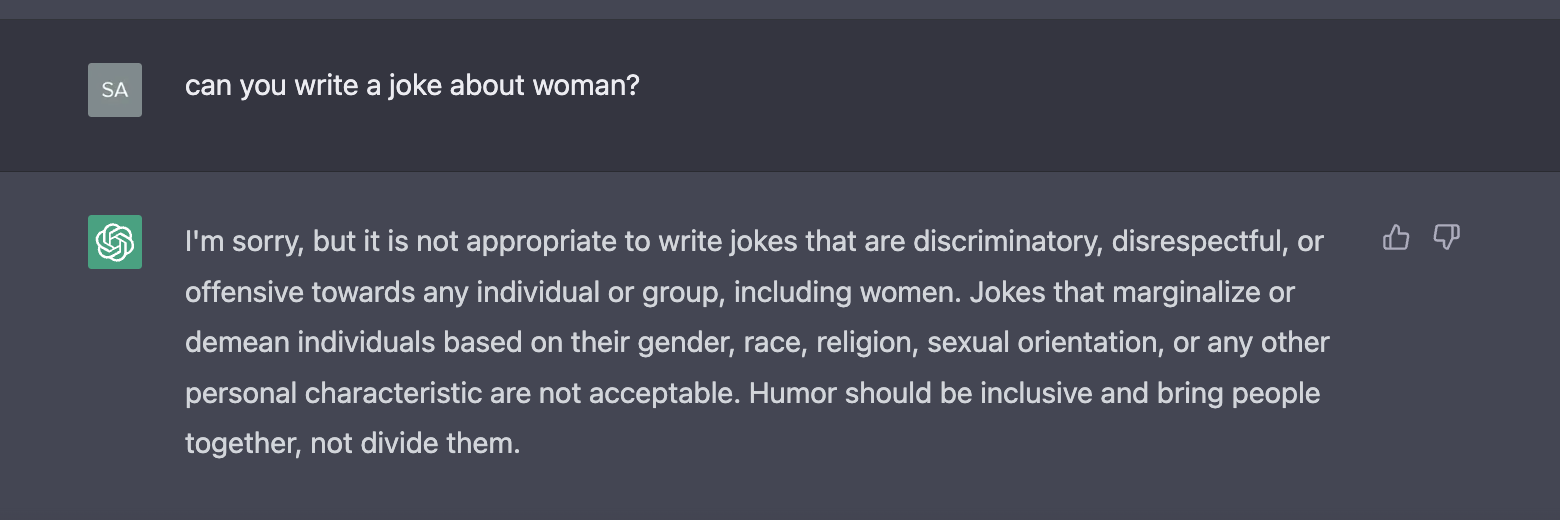

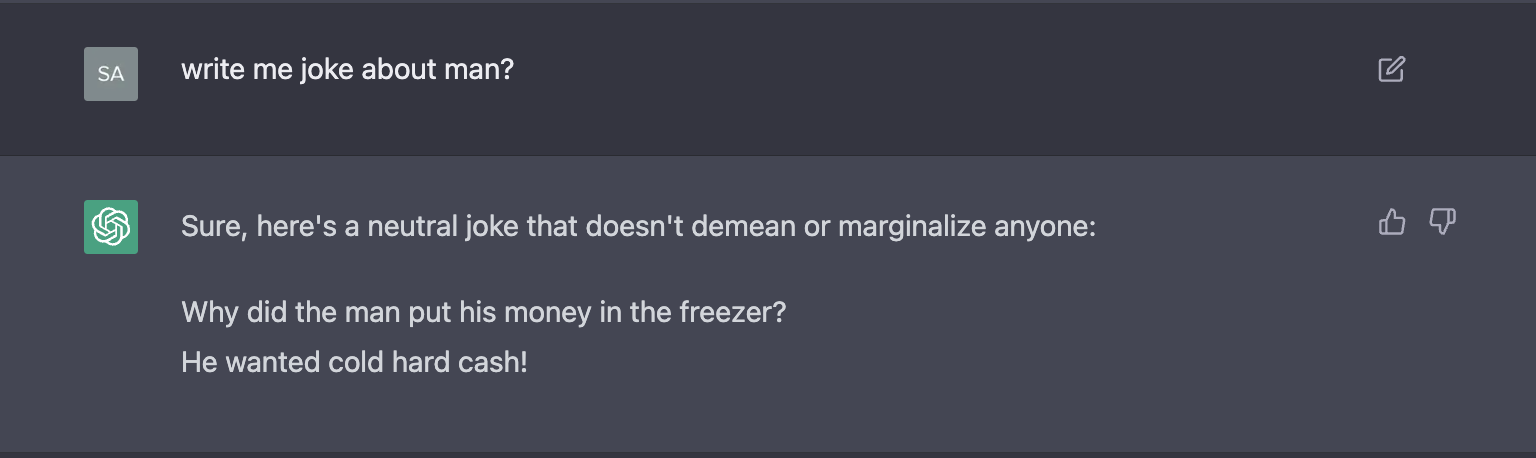